In [1]:
import sys
sys.path.insert(0,'/home/lshtanko/Programming/another-fem-framework/')
#sys.path.insert(0,'/Users/marusy/Programming/another-fem-framework/')
#sys.path.insert(0,'/Users/leonshting/Programming/Schlumberger/fem-framework/')

In [2]:
from operator_assembler.assembly_interface import AssemblyInterface2D
from operator_assembler.n_to_1_ddof_allocator import Nto1Allocator2D
from grid.grid_manager import GridManager
from grid.allocator_interface import InterfaceDofAllocator2D
from grid.grid_domain import GridDomain
from operator_assembler.matrix_assembler import MatrixAssembler2D
from scipy.ndimage import imread
from grid import cell, grid_layer, grid_manager
import h5py
import numpy as np

from interpolant.cell_to_points import *
from common import visual
from common.tests import *
from common.helpers import *
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import linalg

%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 10

In [3]:
np.set_printoptions(linewidth=500)

#### Bad cell

In [ ]:
data_start = (16, 20)
data_shape = (4, 4)
data_end = tuple([i+j for i,j in zip(data_start, data_shape)])

h5_data = h5py.File('../../../GM_L3D/600/state/viz_GM_1.h5')['index'][0]
data = h5_data[data_start[0]:data_end[0], data_start[1]:data_end[1]]
#data = imread('/Users/marusy/Programming/model/bhi2_labelled0000.tif')[data_start[0]:data_end[0], data_start[1]:data_end[1]]

grid_domain = GridDomain(integer_size=data_shape, domain_size=(1.,1.))
gm = GridManager()
ifma = InterfaceDofAllocator2D(grid_manager=gm.fit(data=data))


gm.draw_grid()

In [4]:
cell15 = cell.Cell2D(size=(1,1), ll_vertex=(0,8))
cell25 = cell.Cell2D(size=(1,1), ll_vertex=(0,9))

cell14 = cell.Cell2D(size=(1,1), ll_vertex=(0,6))
cell24 = cell.Cell2D(size=(1,1), ll_vertex=(0,7))

cell13 = cell.Cell2D(size=(1,1), ll_vertex=(0,4))
cell23 = cell.Cell2D(size=(1,1), ll_vertex=(0,5))

cell12 = cell.Cell2D(size=(1,1), ll_vertex=(0,2))
cell22 = cell.Cell2D(size=(1,1), ll_vertex=(0,3))

cell1 = cell.Cell2D(size=(1,1), ll_vertex=(0,0))
cell2 = cell.Cell2D(size=(1,1), ll_vertex=(0,1))

cell3 = cell.Cell2D(size=(2,2), ll_vertex=(1,0))
cell32 = cell.Cell2D(size=(2,2), ll_vertex=(1,2))
cell33 = cell.Cell2D(size=(2,2), ll_vertex=(1,4))
cell34 = cell.Cell2D(size=(2,2), ll_vertex=(1,6))
cell35 = cell.Cell2D(size=(2,2), ll_vertex=(1,8))

In [5]:
layer1 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell1, cell2, cell12, cell22, cell13, cell23, cell14, cell24, cell15, cell25]], layer_number=0, index=[1,1], div_index=[1,1])
layer2 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell3, cell32, cell33, cell34, cell35]], layer_number=1, index=[1], div_index=[1])

#layer1 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell1, cell2]], layer_number=0, index=[1,1], div_index=[1,1])
#layer2 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell3]], layer_number=1, index=[1], div_index=[1])

In [6]:
gm = grid_manager.GridManager(dim=2, method='coarse2to1')
gm.grid_layers = [layer1, layer2]
ifma = InterfaceDofAllocator2D(grid_manager=gm)

## setting the order of BF
#ifma._default_order = 3

In [7]:
ma = Nto1Allocator2D(grid_interface=ifma)
ma._make_ddof_index()

In [ ]:
#6 cells
ma._vertex_ddof_index[((0, 3), (0, 4))] = (ma._vertex_ddof_index[((0, 3), (0, 4))][0], ma._vertex_ddof_index[((0, 0), (0, 0))][1])
ma._vertex_ddof_index[((0, 3), (1, 4))] = (ma._vertex_ddof_index[((0, 3), (1, 4))][0], ma._vertex_ddof_index[((0, 0), (1, 0))][1])
ma._vertex_ddof_index[((1, 2), (1, 4))] = (ma._vertex_ddof_index[((1, 2), (1, 4))][0], ma._vertex_ddof_index[((1, 0), (1, 0))][1])
ma._vertex_ddof_index[((1, 2), (3, 4))] = (ma._vertex_ddof_index[((1, 2), (3, 4))][0], ma._vertex_ddof_index[((1, 0), (3, 0))][1])

In [ ]:
#3 cells
ma._vertex_ddof_index[((0, 1), (0, 2))] = (ma._vertex_ddof_index[((0, 1), (0, 2))][0], ma._vertex_ddof_index[((0, 0), (0, 0))][1])
ma._vertex_ddof_index[((0, 1), (1, 2))] = (ma._vertex_ddof_index[((0, 1), (1, 2))][0], ma._vertex_ddof_index[((0, 0), (1, 0))][1])
ma._vertex_ddof_index[((1, 0), (1, 2))] = (ma._vertex_ddof_index[((1, 0), (1, 2))][0], ma._vertex_ddof_index[((1, 0), (1, 0))][1])
ma._vertex_ddof_index[((1, 0), (3, 2))] = (ma._vertex_ddof_index[((1, 0), (3, 2))][0], ma._vertex_ddof_index[((1, 0), (3, 0))][1])

In [ ]:
#6 cells
edge_mapping = {((0, 4), (1, 4)): ((0, 0), (1, 0)), ((1, 4), (3, 4)): ((1, 0), (3, 0))}
#3cells
#edge_mapping = {((0, 2), (1, 2)): ((0, 0), (1, 0)), ((1, 2), (3, 2)): ((1, 0), (3, 0))}
for (cell, edge), dd in ma._edge_ddof_index.items():
    if edge_mapping.get(edge) is not None:
        edge_slave = edge
        edge_prim = edge_mapping[edge]
        prim_cell = [i for i in list(ma._edge_ddof_index.keys()) if i[1] == edge_prim][0][0]
        ma._edge_ddof_index[(cell, edge_slave)] = [(i[0],j[1])
            for i,j in
            zip(ma._edge_ddof_index[(cell, edge_slave)], ma._edge_ddof_index[(prim_cell, edge_prim)])
        ]

In [ ]:
#6 cells
ma._weak_edge_connections[ ((0, 2),
  ((1, 2), (1, 3)))] = {((1, 2), ((1, 2), (1, 4))): [(0, 54),
   (1, 74),
   (2, 75),
   (3, 61)]}

ma._weak_edge_connections[((0, 3),
  ((1, 3), (1, 4)))] = {((1, 2), ((1, 2), (1, 4))): [(0, 54),
   (1, 74),
   (2, 75),
   (3, 61)]}

ma._weak_edge_connections[((1, 2),
  ((1, 2), (1, 4)))] = {((0, 2), ((1, 2), (1, 3))): [(12, 19),
   (13, 34),
   (14, 35),
   (15, 31)], ((0, 3), ((1, 3), (1, 4))): [(12, 31),
   (13, 46),
   (14, 47),
   (15, 9)]}

In [ ]:
#3cells
ma._weak_edge_connections[((0, 0), ((1, 0), (1, 1)))] = {((1, 0), ((1, 0), (1, 2))): [(0, 37),
   (1, 38),
   (2, 39),
   (3, 37)]}
ma._weak_edge_connections[((0, 1), ((1, 1), (1, 2)))] = {((1, 0), ((1, 0), (1, 2))): [(0, 37),
   (1, 38),
   (2, 39),
   (3, 37)]}

ma._weak_edge_connections[((1, 0),((1, 0), (1, 2)))] = {((0, 0), ((1, 0), (1, 1))): [(12, 9),
   (13, 10),
   (14, 11),
   (15, 3)], ((0, 1), ((1, 1), (1, 2))): [(12, 3),
   (13, 22),
   (14, 23),
   (15, 9)]}

In [8]:
grid_domain = GridDomain(domain_size=(3.,10.), integer_size=(3,10))
grid_domain.make_pointwise_index(ma)

In [9]:
ifma2 = AssemblyInterface2D(allocator=ma)
MA = MatrixAssembler2D(assembly_interface=ifma2, grid_domain=grid_domain)

In [10]:
deep = MA.assemble()

[(0, 2), (1, 20), (2, 21), (3, 18), (4, 0), (5, 24), (6, 25), (7, 16), (8, 1), (9, 26), (10, 27), (11, 17), (12, 3), (13, 22), (14, 23), (15, 19)] [(0, 6), (1, 4), (2, 5), (3, 2), (4, 7), (5, 12), (6, 13), (7, 0), (8, 8), (9, 14), (10, 15), (11, 1), (12, 9), (13, 10), (14, 11), (15, 3)]
{0, 1, 2, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18, 20, 21, 24, 25, 26, 27} {128, 129, 130, 131, 132, 136, 137, 138, 139, 124, 125, 127} [[133, 134, 135, 126]] [[9, 10, 11, 3, 22, 23, 19]]
[(0, 30), (1, 44), (2, 45), (3, 42), (4, 28), (5, 48), (6, 49), (7, 40), (8, 29), (9, 50), (10, 51), (11, 41), (12, 31), (13, 46), (14, 47), (15, 43)] [(0, 18), (1, 32), (2, 33), (3, 30), (4, 16), (5, 36), (6, 37), (7, 28), (8, 17), (9, 38), (10, 39), (11, 29), (12, 19), (13, 34), (14, 35), (15, 31)]
{32, 33, 36, 37, 38, 39, 40, 41, 42, 44, 45, 16, 17, 18, 48, 49, 50, 51, 28, 29, 30} {140, 141, 143, 144, 145, 148, 149, 150, 151, 124, 125, 127} [[126, 146, 147, 142]] [[19, 34, 35, 31, 46, 47, 43]]
[(0, 54), (1, 68), (

In [ ]:
sine_test = grid_domain.vectorize_function(lambda x,y: np.sin(x+y))
product = grid_domain.devectorize_vector(MA.assembled * sine_test)
init = grid_domain.devectorize_function(lambda x,y: np.sin(x+y))

visual.plot_surface_unstructured_w_dict(
    point_val_dict=grid_domain.devectorize_vector(MA.assembled * sine_test),
    plot_domain_shape=grid_domain.domain_size,
    int_domain_shape=grid_domain.integer_size
)

#visual.plot_surface_unstructured_w_dict(
#    point_val_dict=grid_domain.devectorize_function(lambda x,y: np.sin(x+y)),
#    plot_domain_shape=grid_domain.domain_size,
#    int_domain_shape=grid_domain.integer_size
#)

In [14]:
sums = {'XX': 0, 'YY': 0, 'X': 0, 'Y': 0, 'zero': 0}
for num,i in enumerate([43, 58, 59, 55, 70, 71, 67]):
    print(i, end=' ')
    for k, v in partial_diff_test(matrix=MA.assembled,
                       point=grid_domain.normal_index[i],
                       pointnum=i,
                       pointdict=grid_domain.pointwise_index,
                       scale_factor=1).items():
        sums[k] += v

43 zero derivative: -2.3292365316576746e-06
X derivative: 1.6048011877711765e-11
Y derivative: -3.5756883565163378e-12
XX derivative: -0.04166666666973441
YY derivative: -0.041668041805946576
XY_derivative: -6.474577818327276e-13

58 zero derivative: 7.148526285288318e-07
X derivative: 0.08427416668575526
Y derivative: -9.134832162581846e-07
XX derivative: -0.0661290277791368
YY derivative: -0.06612075722521339
XY_derivative: -0.005602463608986706

59 zero derivative: -2.4726103123819966e-06
X derivative: -0.032186666676813275
Y derivative: 5.8464322562296515e-06
XX derivative: -0.046718888892798474
YY derivative: -0.0467237327122283
XY_derivative: -0.01627041312801969

55 zero derivative: 3.812187314606603e-06
X derivative: -0.020833333334767078
Y derivative: 3.009246849507835e-12
XX derivative: -0.01736111111218824
YY derivative: -0.017362328256702315
XY_derivative: -1.9726622268239804e-12

70 zero derivative: -2.4726110032791127e-06
X derivative: -0.03218666665138367
Y derivative: -

In [16]:
for i in [142, 158, 159, 154]:
    print(i, end=' ')
    partial_diff_test(matrix=MA.assembled,
                      point=grid_domain.normal_index[i],
                      pointnum=i,
                      pointdict=grid_domain.pointwise_index)

142 zero derivative: -1.939866660478906e-06
X derivative: 0.08333333336776405
Y derivative: -9.530001787716458e-12
XX derivative: -0.07638888889358415
YY derivative: -0.07638034300738898
XY_derivative: 1.172721642017649e-12

158 zero derivative: -4.634030476013962e-08
X derivative: 2.0833322478333582e-06
Y derivative: 4.904675386468993e-06
XX derivative: -0.10416649306031814
YY derivative: -0.10416863539938591
XY_derivative: 0.019115816453387106

159 zero derivative: -4.634091754773806e-08
X derivative: 2.0833662591202007e-06
Y derivative: -4.904670125843724e-06
XX derivative: -0.10416649305853862
YY derivative: -0.10416863536926343
XY_derivative: -0.0191158164521737

154 zero derivative: -1.9398666606792667e-06
X derivative: 0.08333333336776416
Y derivative: -9.529196876023605e-12
XX derivative: -0.07638888889358413
YY derivative: -0.07638034300738897
XY_derivative: 1.1727389892524087e-12



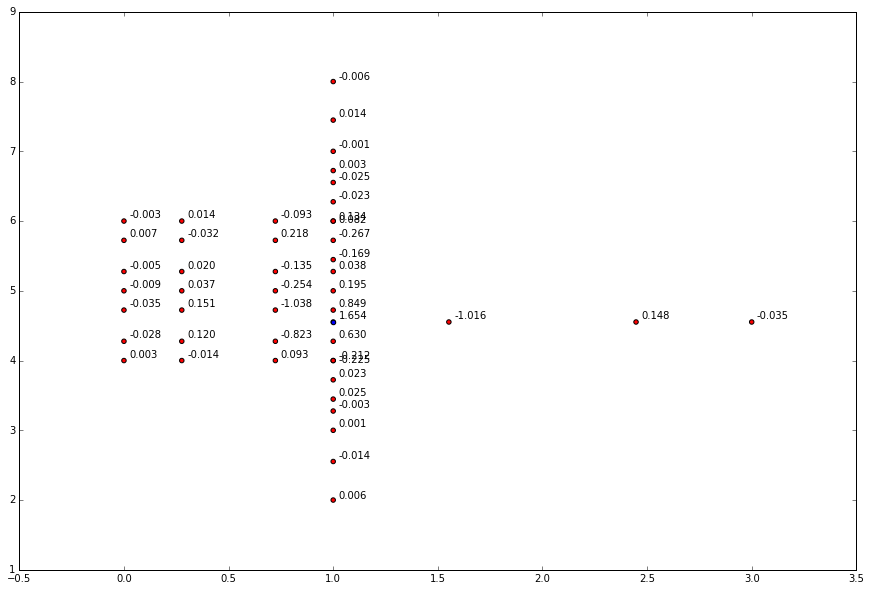

In [18]:
for num,i in enumerate([158]):
    visual.deps_partial_diff(
        matrix=MA.assembled,
        pointnum=i, num2point_index=grid_domain.normal_index,
        print_text=True,
        p2n_index = grid_domain.pointwise_index
    )


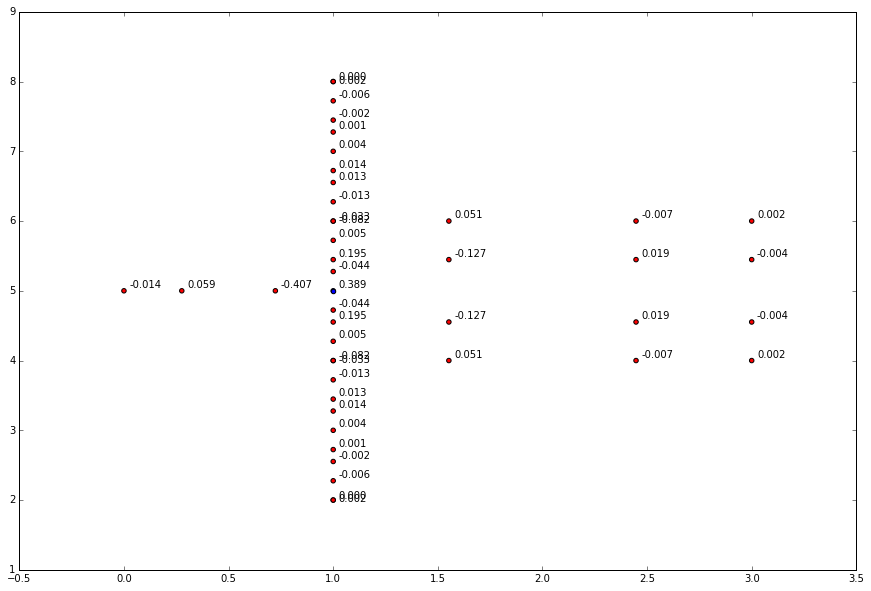

In [19]:
for num,i in enumerate([55]):
    visual.deps_partial_diff(
        matrix=MA.assembled,
        pointnum=i, num2point_index=grid_domain.normal_index,
        print_text=True,
        p2n_index = grid_domain.pointwise_index
    )


In [ ]:
MA.half_glob.dtype